In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

2025-05-01 06:25:25.889176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746080726.134873      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746080726.207241      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"

    metric = root_mean_squared_log_error
    target = "Calories"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Training base models

In [5]:
histgb_params = {
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

cb_params = {
    "border_count": 197,
    "colsample_bylevel": 0.5512194940746528,
    "depth": 10,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 0.8315140039900148,
    "learning_rate": 0.04835894985543038,
    "min_child_samples": 248,
    "random_state": 42,
    "random_strength": 0.269215705791639,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [6]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [7]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_log_error: 0.0610 - Time: 128.18 s
--- Fold 1 - root_mean_squared_log_error: 0.0616 - Time: 115.55 s
--- Fold 2 - root_mean_squared_log_error: 0.0608 - Time: 144.54 s
--- Fold 3 - root_mean_squared_log_error: 0.0621 - Time: 118.38 s
--- Fold 4 - root_mean_squared_log_error: 0.0608 - Time: 142.61 s

------ Overall root_mean_squared_log_error: 0.0612 - Mean root_mean_squared_log_error: 0.0612 ± 0.0005 - Time: 651.62 s


## LightGBM (gbdt)

In [8]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.58626	valid_0's l2: 12.8612
[1000]	valid_0's rmse: 3.57258	valid_0's l2: 12.7633
Early stopping, best iteration is:
[1164]	valid_0's rmse: 3.57037	valid_0's l2: 12.7476
--- Fold 0 - root_mean_squared_log_error: 0.0618 - Time: 40.65 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.64538	valid_0's l2: 13.2888
[1000]	valid_0's rmse: 3.62694	valid_0's l2: 13.1547
[1500]	valid_0's rmse: 3.62361	valid_0's l2: 13.1306
Early stopping, best iteration is:
[1425]	valid_0's rmse: 3.62325	valid_0's l2: 13.1279
--- Fold 1 - root_mean_squared_log_error: 0.0622 - Time: 45.14 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.58853	valid_0's l2: 12.8776
[1000]	valid_0's rmse: 3.57473	valid_0's l2: 12.7787
Early stopping, best iteration is:
[1128]	valid_0's rmse: 3.5741	valid_0's l2: 12.7742
--- Fold 2 - root_mean_squa

## LightGBM (goss)

In [9]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.88379	valid_0's l2: 15.0838
[1000]	valid_0's rmse: 3.65662	valid_0's l2: 13.3709
[1500]	valid_0's rmse: 3.6177	valid_0's l2: 13.0878
[2000]	valid_0's rmse: 3.60195	valid_0's l2: 12.9741
[2500]	valid_0's rmse: 3.59361	valid_0's l2: 12.914
[3000]	valid_0's rmse: 3.58981	valid_0's l2: 12.8867
[3500]	valid_0's rmse: 3.58735	valid_0's l2: 12.8691
Early stopping, best iteration is:
[3546]	valid_0's rmse: 3.58712	valid_0's l2: 12.8675
--- Fold 0 - root_mean_squared_log_error: 0.0653 - Time: 188.26 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.96722	valid_0's l2: 15.7388
[1000]	valid_0's rmse: 3.71884	valid_0's l2: 13.8298
[1500]	valid_0's rmse: 3.6756	valid_0's l2: 13.5101
[2000]	valid_0's rmse: 3.65979	valid_0's l2: 13.3941
[2500]	valid_0's rmse: 3.65127	valid_0's l2: 13.3317
[3000]	valid_0's rmse: 3.64734	valid_0's l2: 13.3031
Early stoppin

## XGBoost

In [10]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500
}

xgb_trainer.fit(X, y, fit_args)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:60.21653
[500]	validation_0-rmse:4.01644
[1000]	validation_0-rmse:3.71865
[1500]	validation_0-rmse:3.65990
[2000]	validation_0-rmse:3.64129
[2500]	validation_0-rmse:3.63325
[3000]	validation_0-rmse:3.62950
[3500]	validation_0-rmse:3.62516
[4000]	validation_0-rmse:3.62282
[4500]	validation_0-rmse:3.62130
[4534]	validation_0-rmse:3.62128
--- Fold 0 - root_mean_squared_log_error: 0.0645 - Time: 190.91 s

[0]	validation_0-rmse:60.39554
[500]	validation_0-rmse:4.04390
[1000]	validation_0-rmse:3.78810
[1500]	validation_0-rmse:3.73211
[2000]	validation_0-rmse:3.71423
[2500]	validation_0-rmse:3.70553
[3000]	validation_0-rmse:3.70084
[3500]	validation_0-rmse:3.69861
[4000]	validation_0-rmse:3.69664
[4500]	validation_0-rmse:3.69549
[5000]	validation_0-rmse:3.69510
[5500]	validation_0-rmse:3.69449
[5912]	validation_0-rmse:3.69439
--- Fold 1 - root_mean_squared_log_error: 0.0661 - Time: 232.23 s

[0]	validation_0-rmse:60.48680
[500]	validation_0-rmse:4.

## CatBoost

In [11]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 59.5375410	test: 59.3684542	best: 59.3684542 (0)	total: 135ms	remaining: 11m 13s
500:	learn: 3.3568303	test: 3.5500817	best: 3.5500817 (500)	total: 29.9s	remaining: 4m 28s
1000:	learn: 3.2516987	test: 3.5393552	best: 3.5392873 (990)	total: 59s	remaining: 3m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.539149246
bestIteration = 1009

Shrink model to first 1010 iterations.
--- Fold 0 - root_mean_squared_log_error: 0.0602 - Time: 66.98 s

0:	learn: 59.4990981	test: 59.5447343	best: 59.5447343 (0)	total: 88.7ms	remaining: 7m 23s
500:	learn: 3.3533082	test: 3.5963772	best: 3.5963219 (497)	total: 29.9s	remaining: 4m 28s
1000:	learn: 3.2469856	test: 3.5844221	best: 3.5843558 (973)	total: 59.3s	remaining: 3m 56s
1500:	learn: 3.1732106	test: 3.5829661	best: 3.5821742 (1414)	total: 1m 28s	remaining: 3m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.582174207
bestIteration = 1414

Shrink model to first 141

## Yggdrasil

In [12]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [13]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_log_error: 0.0621 - Time: 110.15 s
--- Fold 1 - root_mean_squared_log_error: 0.0619 - Time: 158.54 s
--- Fold 2 - root_mean_squared_log_error: 0.0621 - Time: 84.17 s
--- Fold 3 - root_mean_squared_log_error: 0.0637 - Time: 198.88 s
--- Fold 4 - root_mean_squared_log_error: 0.0626 - Time: 103.06 s

------ Overall root_mean_squared_log_error: 0.0625 - Mean root_mean_squared_log_error: 0.0625 ± 0.0006 - Time: 656.81 s


## Neural networks

In [14]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [15]:
scaler = StandardScaler().set_output(transform="pandas")

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [16]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [17]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

2025-05-01 07:37:25.481247: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
nn_bag = BaggingRegressor(
    nn_model,
    n_estimators=5,
    random_state=CFG.seed,
)

In [19]:
nn_trainer = Trainer(
    nn_bag,
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_log_error,
    task="regression"
)

nn_trainer.fit(X, y)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training BaggingRegressor



2025-05-01 07:37:26.175997: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 07:37:31.293012: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 0 - root_mean_squared_log_error: 0.0616 - Time: 615.48 s


2025-05-01 07:47:42.260112: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 07:47:47.304495: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 1 - root_mean_squared_log_error: 0.0631 - Time: 508.25 s


2025-05-01 07:56:11.284181: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 07:58:35.405901: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 2 - root_mean_squared_log_error: 0.0615 - Time: 728.11 s


2025-05-01 08:08:20.453896: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 08:08:25.520016: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 3 - root_mean_squared_log_error: 0.0626 - Time: 511.16 s


2025-05-01 08:16:52.423978: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 08:19:28.906069: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 4 - root_mean_squared_log_error: 0.0610 - Time: 777.67 s

------ Overall root_mean_squared_log_error: 0.0620 - Mean root_mean_squared_log_error: 0.0620 ± 0.0007 - Time: 3144.94 s


2025-05-01 08:29:50.646670: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 08:29:55.955455: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Ensembling with Ridge

In [20]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [21]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [22]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-01 08:30:24,234] A new study created in memory with name: no-name-7291c16c-26f6-424b-aef9-2ccc833d4ea4
[I 2025-05-01 08:30:44,036] Trial 0 finished with value: 0.060185033740438945 and parameters: {'alpha': 0.9435888537466808, 'tol': 0.008593118075630846}. Best is trial 0 with value: 0.060185033740438945.
[I 2025-05-01 08:30:44,076] Trial 1 finished with value: 0.06018503669240121 and parameters: {'alpha': 9.071388275782766, 'tol': 0.008528668423241029}. Best is trial 0 with value: 0.060185033740438945.
[I 2025-05-01 08:30:44,085] Trial 3 finished with value: 0.06018503408998316 and parameters: {'alpha': 1.9060918994086151, 'tol': 0.006585634395570934}. Best is trial 0 with value: 0.060185033740438945.
[I 2025-05-01 08:30:44,120] Trial 2 finished with value: 0.06018503365943132 and parameters: {'alpha': 0.7205216477631415, 'tol': 0.006840153392029101}. Best is trial 2 with value: 0.06018503365943132.
[I 2025-05-01 08:31:01,334] Trial 6 finished with value: 0.0601850348500873

In [23]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 0.0011846838674783545,
  "tol": 0.006567771135338089
}


In [24]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = ridge_trainer.predict(X_test)

Training Ridge

--- Fold 0 - root_mean_squared_log_error: 0.0599 - Time: 0.17 s
--- Fold 1 - root_mean_squared_log_error: 0.0605 - Time: 0.13 s
--- Fold 2 - root_mean_squared_log_error: 0.0597 - Time: 0.12 s
--- Fold 3 - root_mean_squared_log_error: 0.0610 - Time: 0.12 s
--- Fold 4 - root_mean_squared_log_error: 0.0599 - Time: 0.12 s

------ Overall root_mean_squared_log_error: 0.0602 - Mean root_mean_squared_log_error: 0.0602 ± 0.0005 - Time: 4.92 s


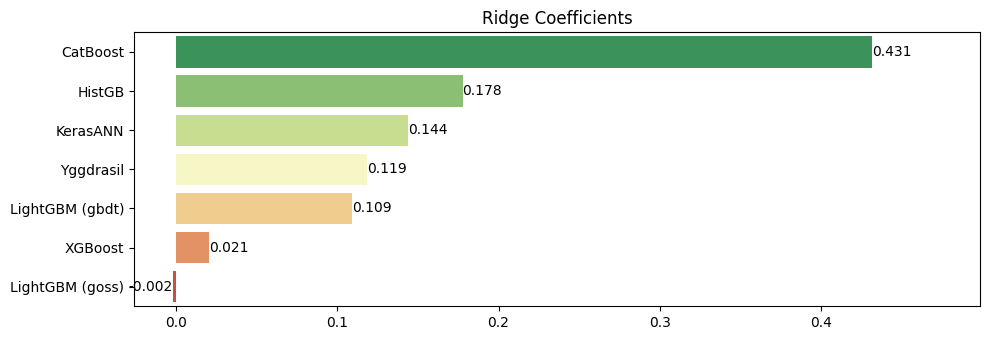

In [25]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [26]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.208661
1,750001,108.078726
2,750002,87.296532
3,750003,125.706646
4,750004,76.145569


# Results

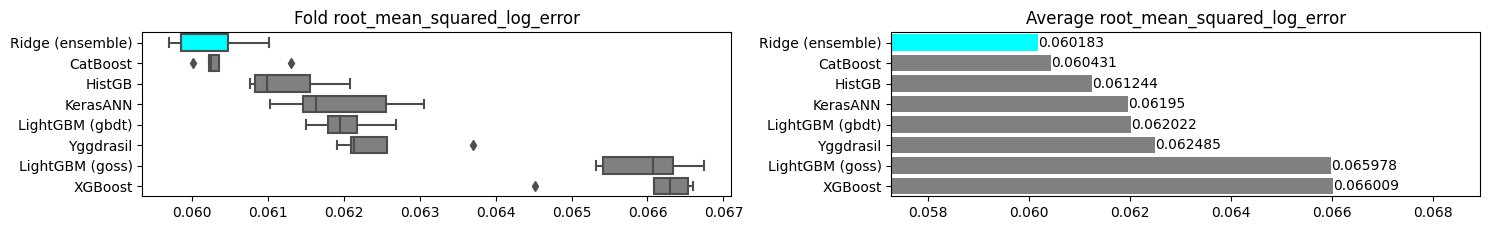

In [27]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()